In [1]:
from dblinea import DBBase
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os


## Spec Sample

In [2]:
db=DBBase()
schema = "des_dr2"  
tablename = "des_dr2.public_pz_training_set"

```sql

SELECT * 
FROM des_dr2.public_pz_training_set 
WHERE mag_auto_i_dered>16 AND mag_auto_r_dered>16 AND mag_auto_g_dered - mag_auto_r_dered BETWEEN -1 AND 4 AND mag_auto_r_dered - mag_auto_i_dered BETWEEN -1 AND 4 AND mag_auto_i_dered - mag_auto_z_dered BETWEEN -1 AND 4


```



In [4]:
query = 'SELECT * FROM des_dr2.public_pz_training_set WHERE mag_auto_i_dered>16 AND mag_auto_r_dered>16 AND mag_auto_g_dered - mag_auto_r_dered BETWEEN -1 AND 4 AND mag_auto_r_dered - mag_auto_i_dered BETWEEN -1 AND 4 AND mag_auto_i_dered - mag_auto_z_dered BETWEEN -1 AND 4'


In [5]:
df_origin = db.fetchall_df(query)

In [6]:
df_origin

,spec_id,z,err_z,flag,source,flag_des,coadd_object_id,ra,dec,mag_auto_g_dered,mag_auto_r_dered,mag_auto_i_dered,mag_auto_z_dered,mag_auto_y_dered,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y
0,123965,0.116858,0.000183,3.0,6DF,3,943508938,329.321221,-40.602543,17.459648,16.701464,16.337524,16.092995,15.971371,0.001439,0.000954,0.001089,0.001607,0.005120
1,123966,0.301409,0.000150,4.0,6DF,4,943510809,329.334069,-40.603863,17.726744,17.574804,17.564592,17.353552,17.593048,0.000715,0.000725,0.001043,0.001577,0.006892
2,123992,0.234609,0.000150,4.0,6DF,4,948663390,331.439744,-40.971529,18.529400,18.338650,17.999672,18.071312,17.983315,0.001417,0.001492,0.001679,0.003603,0.009086
3,123993,0.147415,0.000150,4.0,6DF,4,945752705,330.939548,-40.531142,18.018383,17.416050,17.044855,16.912973,16.843912,0.001783,0.001381,0.001550,0.002662,0.009134
4,280906,0.174000,99.000000,3.0,2DF,3,960508194,336.753972,-40.128761,18.927296,18.380819,18.123314,17.984945,17.946331,0.003810,0.003214,0.003656,0.006411,0.021424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457586,1179902,0.559408,0.000098,0.0,SDSS_DR14,4,911998643,318.417689,-0.581618,22.170662,20.354282,19.497082,19.120827,18.969761,0.050562,0.013519,0.009071,0.011625,0.044242
457587,1180437,0.492449,0.000132,0.0,SDSS_DR14,4,910182939,318.837092,-1.746145,21.211683,19.555185,18.921442,18.566652,18.495165,0.040050,0.010888,0.009224,0.012465,0.064211
457588,1180572,0.602048,0.000158,0.0,SDSS_DR14,4,916406387,320.387536,-2.264580,22.782799,20.705061,19.846029,19.482748,99.000000,0.251415,0.045982,0.032604,0.040286,99.000000
457589,1180438,0.326851,0.000136,0.0,SDSS_DR14,4,913627480,319.063850,-1.699792,21.644707,20.102846,19.516445,19.131275,19.062071,0.049070,0.020587,0.015738,0.017882,0.086862


In [7]:
g = df_origin['mag_auto_g_dered']
r = df_origin['mag_auto_r_dered']
i = df_origin['mag_auto_i_dered']
z = df_origin['mag_auto_z_dered']
y = df_origin['mag_auto_y_dered']

df_origin['g-r'] = g-r
df_origin['r-i'] = r-i
df_origin['i-z'] = i-z
df_origin['z-y'] = z-y

In [202]:
spec_sample = df_origin


### Selecting catalogs 

In [ ]:
mask1 = ~(spec_sample['source'] == 'XXL_AAOMEGA')
mask2 = ~(spec_sample['source'] == 'PANSTARRS')
mask3 = ~(spec_sample['source'] == 'STALIN')
mask4 = ~(spec_sample['source'] == 'PRIMUS')
new_sample = spec_sample[mask1 & mask2 & mask3 & mask4]

## Cutting erros 


In [203]:
spec_sample = spec_sample[(spec_sample['magerr_auto_g']< 0.1086) & (spec_sample['magerr_auto_r']< 0.1086) & (spec_sample['magerr_auto_i']< 0.1086)& (spec_sample['magerr_auto_z']< 0.1086)& (spec_sample['magerr_auto_y']< 0.1086)]


## Table per survey

In [292]:
surveys = set(spec_sample['source'])
survey=[]
matchings=[]
z_mean=[]
z_max=[]
z_min=[]
for surv in surveys:
    survey.append(surv)
    mask = spec_sample[spec_sample['source']==surv]
    matchings.append(len(mask))
    z_mean.append(round(np.mean(mask['z']),2))
    z_max.append(round(max(mask['z']),2))
    z_min.append(round(min(mask['z']),2))
    

In [293]:
table = pd.DataFrame({'survey':survey, 'matchings':matchings, 'z_mean':z_mean, 'z_min':z_min, 'z_max':z_max})

In [296]:
table.sort_values(by='matchings', ascending = False)

,survey,matchings,z_mean,z_min,z_max
13,SDSS_DR14,122987,0.48,0.00,1.98
0,2DF,51357,0.13,0.00,3.00
10,GAMA,28107,0.23,0.00,0.79
11,2dFLenS,23451,0.35,0.00,4.69
1,VIPERS,8761,0.59,0.04,1.44
16,SAGA,4669,0.32,0.01,3.34
8,WIGGLEZ,3753,0.54,0.04,4.24
4,6DF,2725,0.24,0.00,3.38
18,CLASH-VLT,1535,0.33,0.02,4.15
14,VVDS,1354,0.41,0.03,0.98


## Looking the 12 largest catalogs

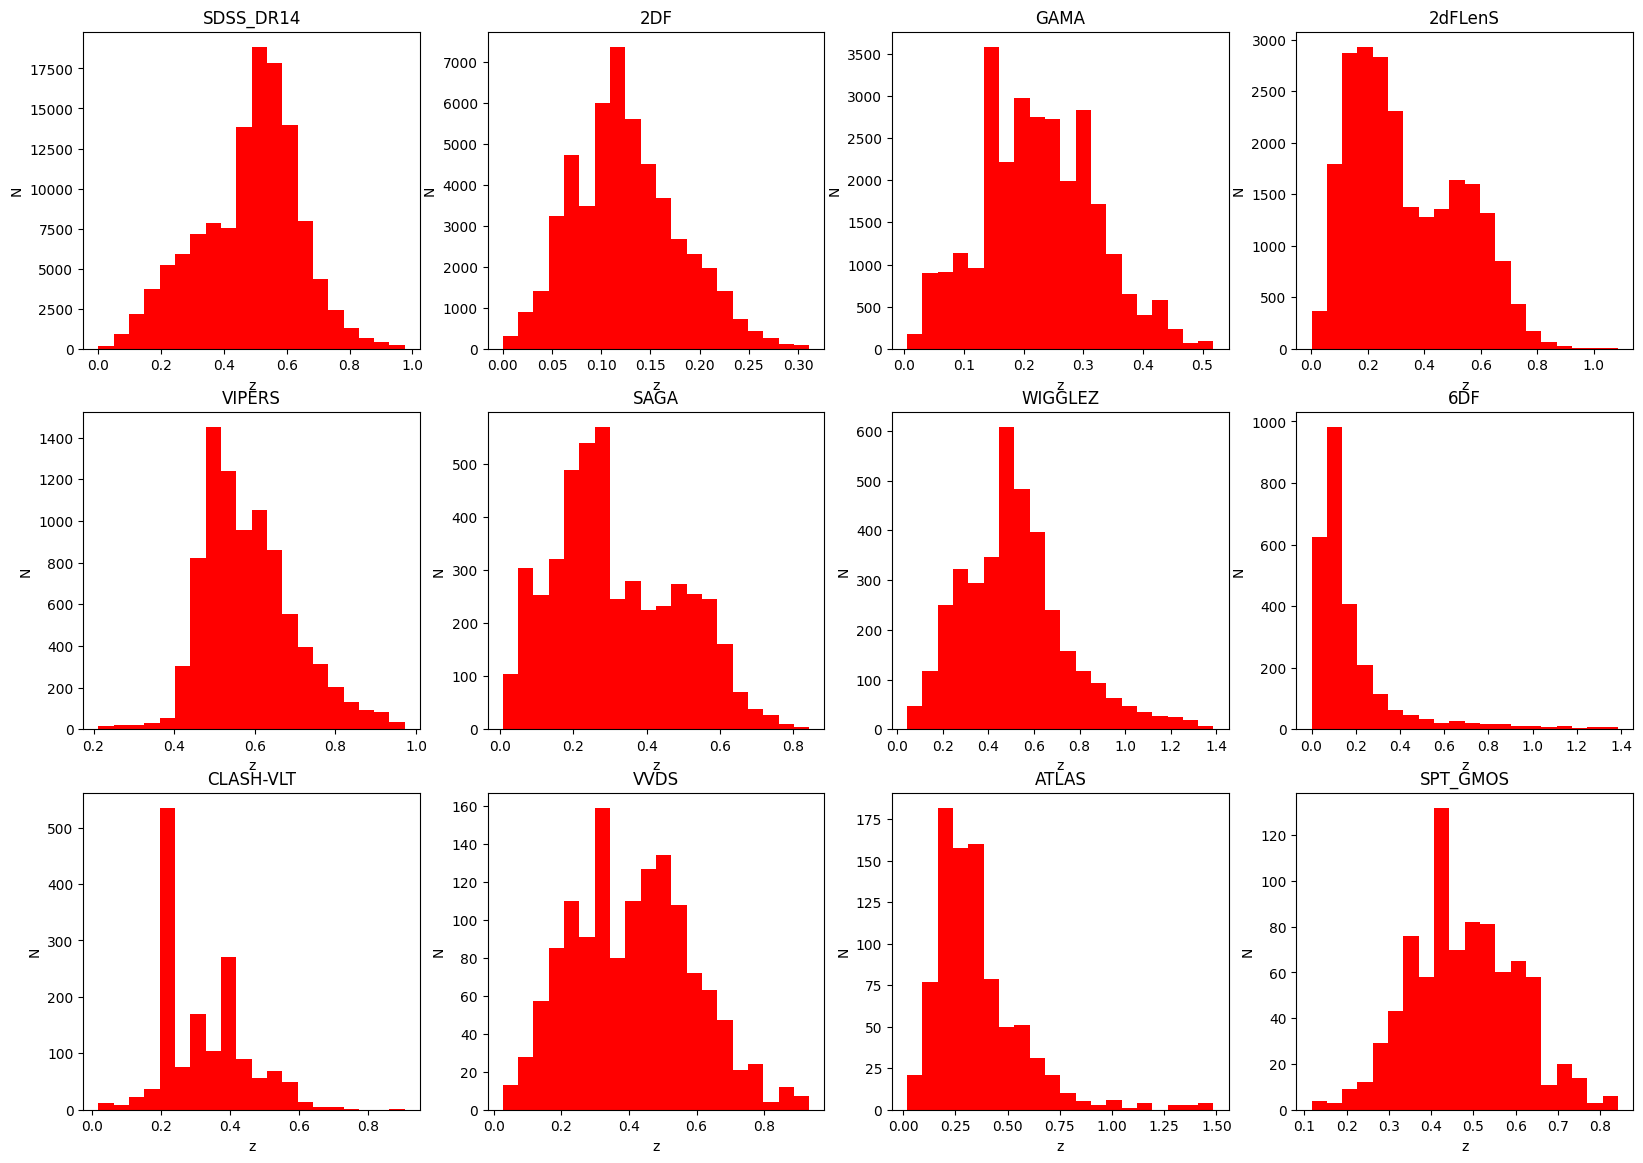

In [341]:
element_count = spec_sample['source'].value_counts().reset_index()
i=1
plt.figure(figsize = (20,14))
for catalog in element_count[:12]['source']:
    redshift = spec_sample[spec_sample['source'] == catalog]['z']
    plt.subplot(3, 4, i)
    plt.xlabel('z')
    plt.ylabel('N')
    std = np.std(redshift)
    mean = np.mean(redshift)
    redshift = redshift[(redshift< mean+3*std) & (redshift> mean-3*std)] #removing outliers with 3 std
    plt.hist(redshift, bins = 20, color = 'red')
    plt.title(catalog)
    i+=1


## View of the sky

In [299]:
! wget https://raw.githubusercontent.com/kadrlica/skymap/master/skymap/data/des-round19-poly.txt  

--2023-09-30 13:36:56--  https://raw.githubusercontent.com/kadrlica/skymap/master/skymap/data/des-round19-poly.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9947 (9.7K) [text/plain]
Saving to: ‘des-round19-poly.txt’

des-round19-poly.tx 100%[===================>]   9.71K  --.-KB/s    in 0s      

2023-09-30 13:36:57 (29.1 MB/s) - ‘des-round19-poly.txt’ saved [9947/9947]



In [300]:
foot_ra, foot_dec = np.loadtxt('des-round19-poly.txt', unpack=True)

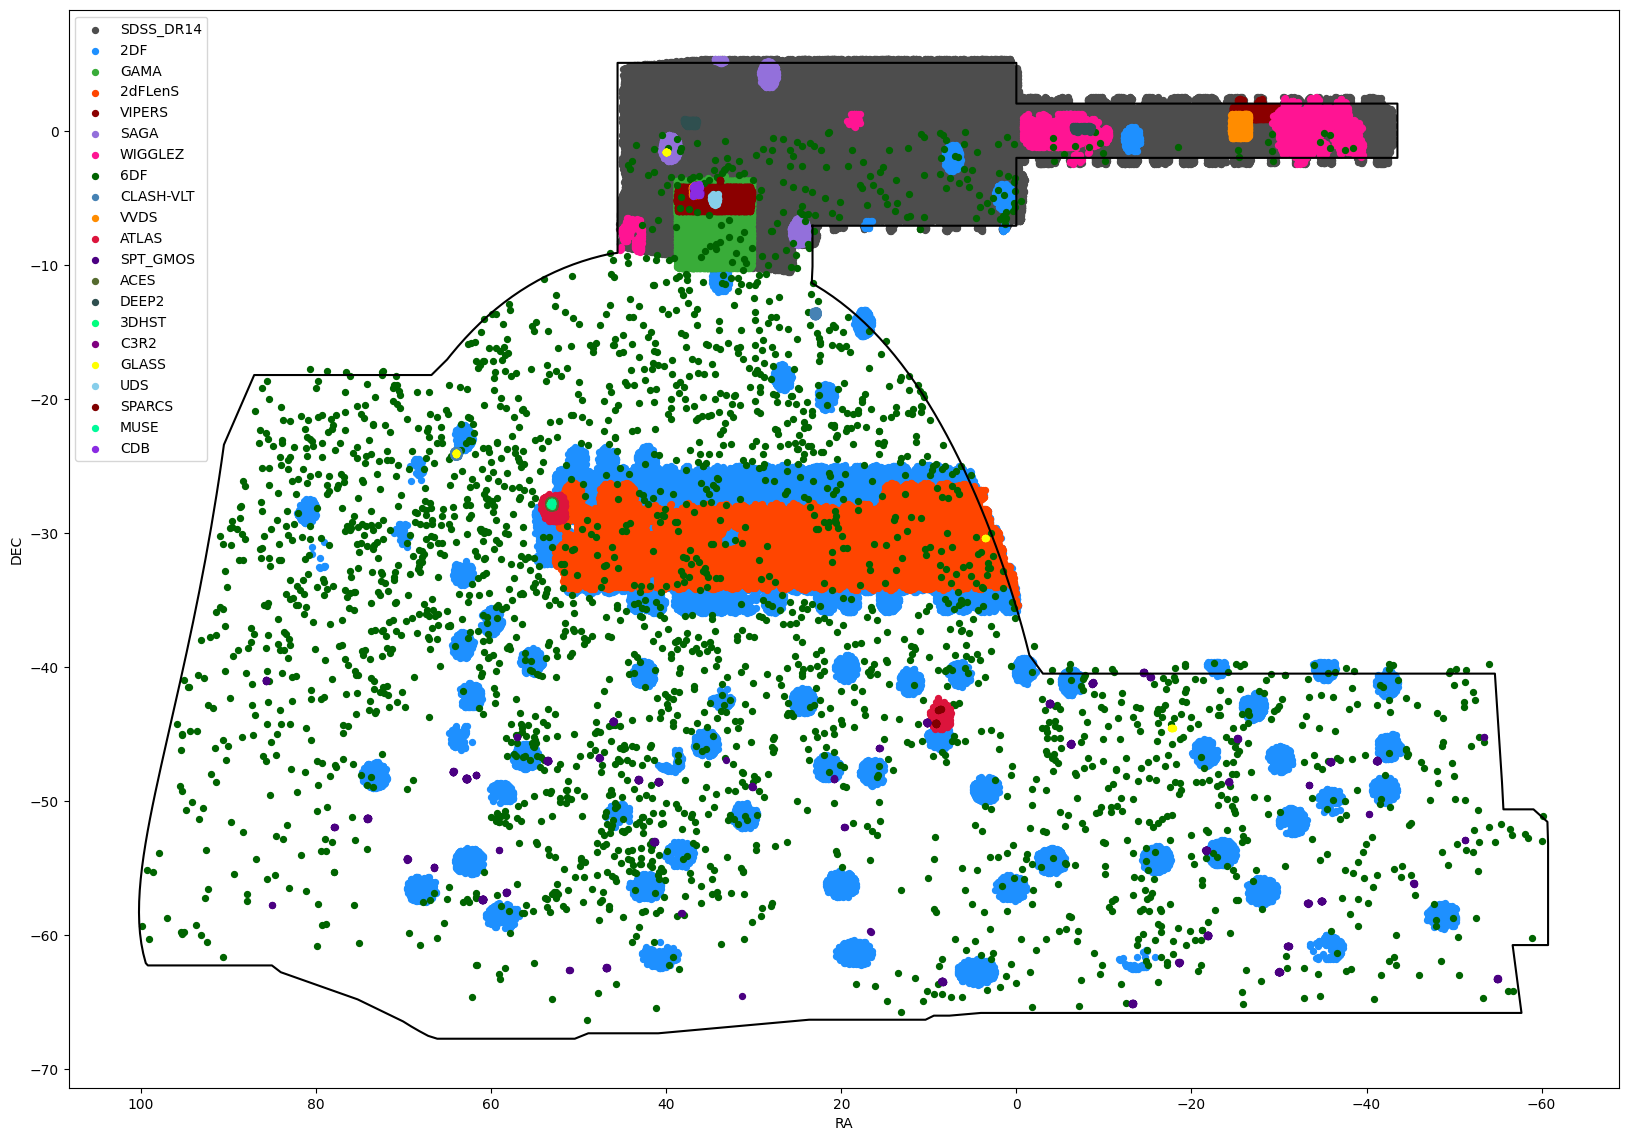

<Figure size 640x480 with 0 Axes>

In [362]:
i=0
colors = [
    '#4D4D4D', '#1E90FF', '#39AC39', '#FF4500', '#8B0000',
    '#9370DB', '#FF1493', '#006400', '#4682B4', '#FF8C00',
    '#DC143C', '#4B0082', '#556B2F', '#2F4F4F', '#00FF7F',
    '#800080', '#FFFF00', '#87CEEB', '#800000', '#00FA9A',
    '#8A2BE2'
]


spec_sample.loc[spec_sample['ra']>150,'ra'] = spec_sample[spec_sample['ra']>150]['ra'] - max(spec_sample['ra']) #For 'tank' format
plt.figure(figsize = (20,14))

for catalog in element_count[:]['source']:
    ra = spec_sample[spec_sample['source'] == catalog]['ra']
    dec = spec_sample[spec_sample['source'] == catalog]['dec']
    plt.scatter(ra, dec, color = colors[i], s=18 , label = catalog)
    i+=1
plt.plot(58*np.radians(foot_ra), 58*np.radians(foot_dec), '-', color='black')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend(loc = 2)
plt.gca().invert_xaxis()
plt.show()
plt.savefig('Sky-View.png')

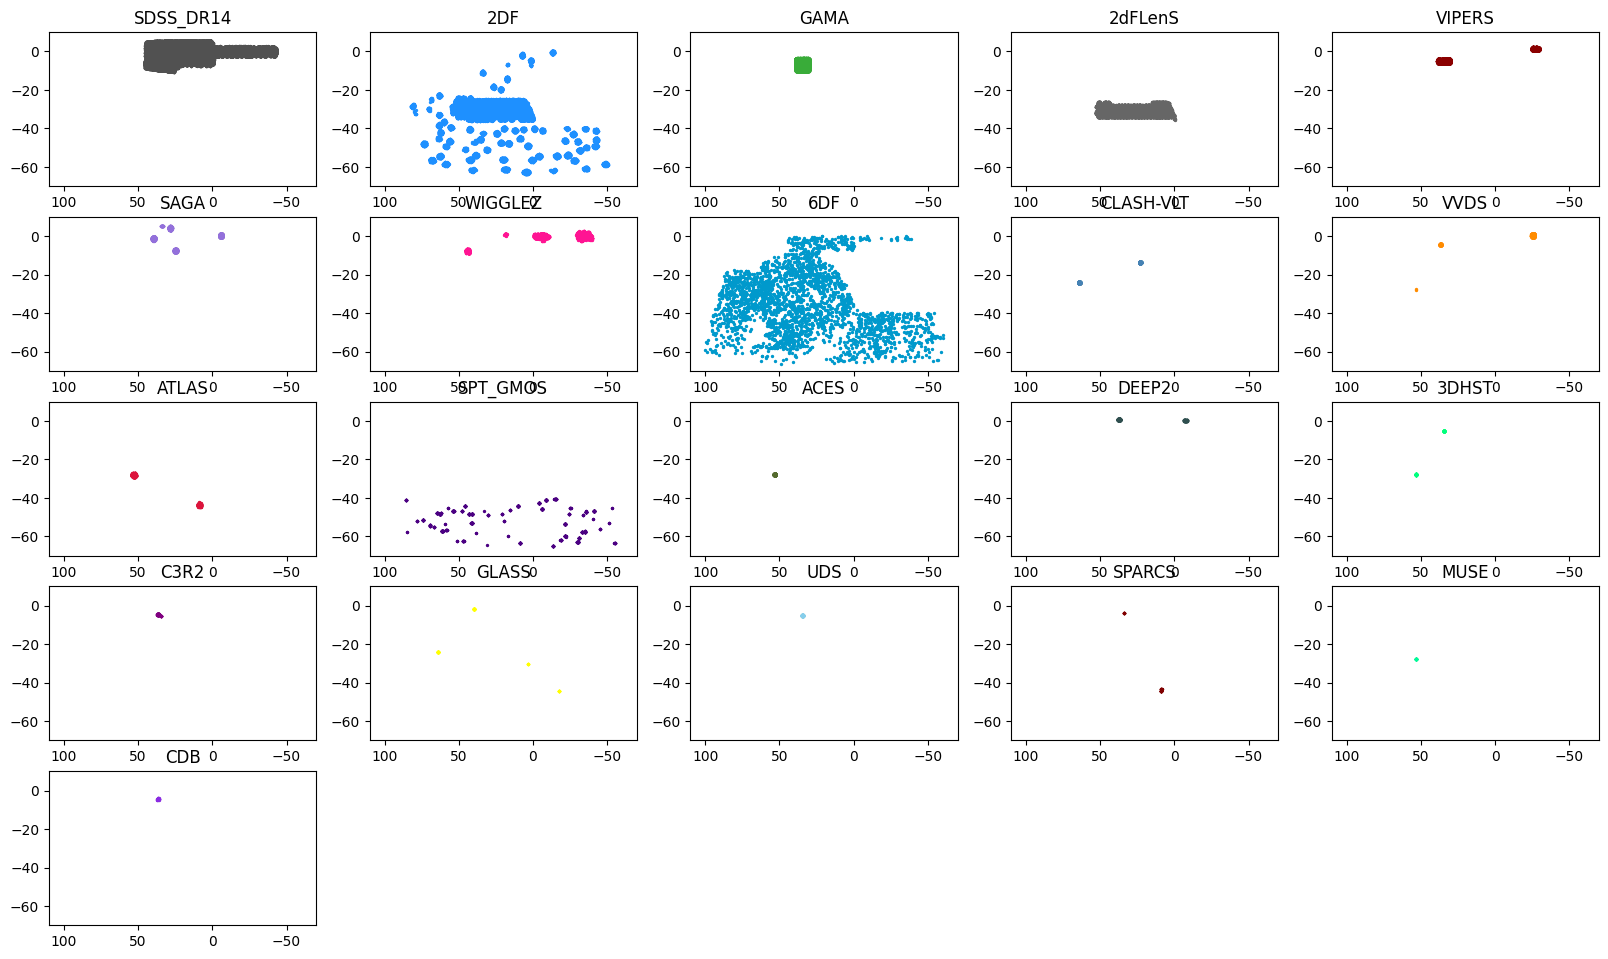

In [355]:
i=0
colors = [
    '#515151', '#1E90FF', '#39AC39', '#666666', '#8B0000',
    '#9370DB', '#FF1493', '#0099CC', '#4682B4', '#FF8C00',
    '#DC143C', '#4B0082', '#556B2F', '#2F4F4F', '#00FF7F',
    '#800080', '#FFFF00', '#87CEEB', '#800000', '#00FA9A',
    '#8A2BE2'
]


plt.figure(figsize = (20,14))
for catalog in element_count['source']:
    ra = spec_sample[spec_sample['source'] ==catalog]['ra']
    dec = spec_sample[spec_sample['source'] ==catalog]['dec']
    plt.subplot(6,5,i+1)
    plt.scatter(ra, dec, color = colors[i], s=2)
    plt.xlim((110,-70))
    plt.ylim((-70,10))
    plt.title(catalog)
    i+=1
plt.show()

# Query for random phot samples

In [16]:
tablename2 = "coadd_objects"

```sql
SELECT ra, dec, extended_class_coadd, mag_auto_g, mag_auto_r, mag_auto_i, mag_auto_z, mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y, 
FROM des_dr2.coadd_objects 
WHERE extended_class_coadd>=2 AND flags_g<4 AND flags_r<4 AND flags_i<4 AND flags_z<4 AND flags_y<4
AND mag_auto_i>16 AND mag_auto_r>16 AND mag_auto_g - mag_auto_r BETWEEN -1 AND 4 AND mag_auto_r - mag_auto_i BETWEEN -1 AND 4 AND mag_auto_i - mag_auto_z BETWEEN -1 AND 4
ORDER BY RANDOM()
LIMIT 457591;

```

In [17]:


query2 = 'SELECT erra_image, ra, dec, extended_class_coadd, mag_auto_g, mag_auto_r, mag_auto_i, mag_auto_z, mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE extended_class_coadd>=2 AND flags_g<4 AND flags_r<4 AND flags_i<4 AND flags_z<4 AND flags_y<4 AND mag_auto_i>16 AND mag_auto_r>16 AND mag_auto_g - mag_auto_r BETWEEN -1 AND 4 AND mag_auto_r - mag_auto_i BETWEEN -1 AND 4 AND mag_auto_i - mag_auto_z BETWEEN -1 AND 4 ORDER BY RANDOM() LIMIT 457591;'



In [18]:
%%time
phot_sample = db.fetchall_df(query2)

CPU times: user 6.19 s, sys: 547 ms, total: 6.73 s
Wall time: 41min 28s


# Spec and Phot samples

In [19]:
phot_sample

,erra_image,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y
0,0.344158,353.296287,-63.720504,2,24.812477,24.728436,24.533684,24.451935,99.000000,0.159212,0.190849,0.316175,0.477912,99.000000
1,0.182534,92.246212,-43.241802,2,24.351748,23.591198,23.334475,22.934868,22.835552,0.186489,0.123539,0.178380,0.219192,0.775448
2,0.044309,91.315367,-49.648968,3,22.351542,20.802876,20.313459,20.012133,19.941870,0.037718,0.011799,0.015504,0.018831,0.082163
3,0.240523,69.341168,-48.673490,2,24.868607,25.008471,24.274780,24.480385,24.168421,0.247717,0.362586,0.302873,0.755548,2.160678
4,0.097609,81.195307,-42.022416,3,22.503443,21.530233,21.170383,21.095652,21.278318,0.051315,0.026777,0.033371,0.060028,0.261058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457586,0.191939,71.279868,-62.798774,2,24.071342,23.466057,23.159763,22.853836,25.428181,0.139482,0.106331,0.186429,0.311225,7.921712
457587,0.298875,88.537662,-49.542174,2,25.739710,25.822796,24.827198,24.903347,23.834000,0.246232,0.355668,0.239639,0.534160,0.709140
457588,0.189862,337.923212,-52.218367,3,24.845892,23.377193,22.509766,22.274712,21.793535,0.277663,0.105255,0.076058,0.120016,0.283544
457589,0.281228,68.569762,-39.377484,2,25.815763,25.157600,24.653303,23.644135,99.000000,0.436364,0.282543,0.344497,0.246513,99.000000


In [20]:
gr_spec = spec_sample['mag_auto_g_dered']-spec_sample['mag_auto_r_dered']
ri_spec = spec_sample['mag_auto_r_dered']-spec_sample['mag_auto_i_dered']
iz_spec = spec_sample['mag_auto_i_dered']-spec_sample['mag_auto_z_dered']
gr_phot = phot_sample['mag_auto_g']-phot_sample['mag_auto_r']
ri_phot = phot_sample['mag_auto_r']-phot_sample['mag_auto_i']
iz_phot = phot_sample['mag_auto_i']-phot_sample['mag_auto_z']

## Graphs

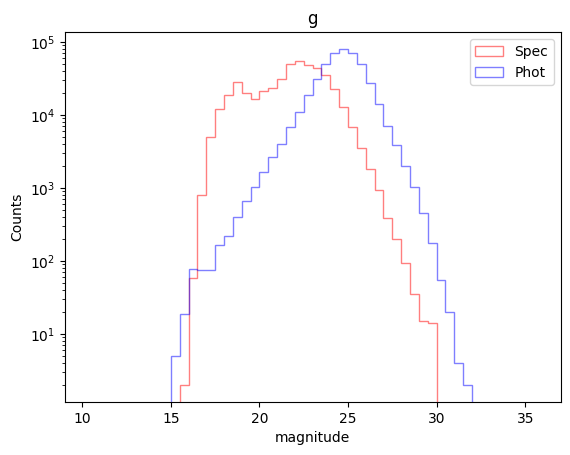

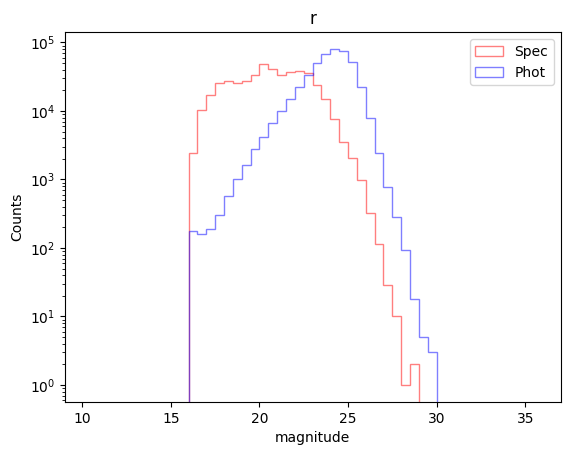

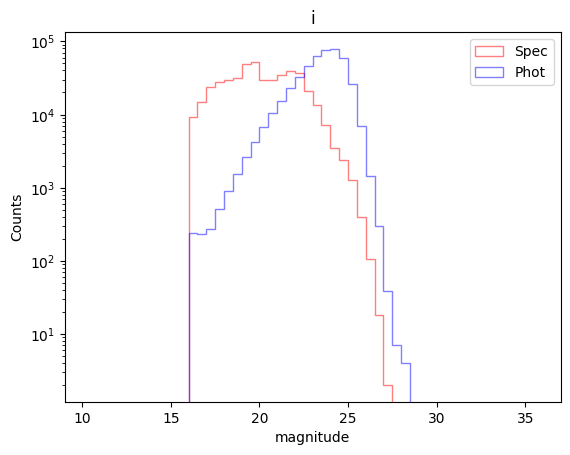

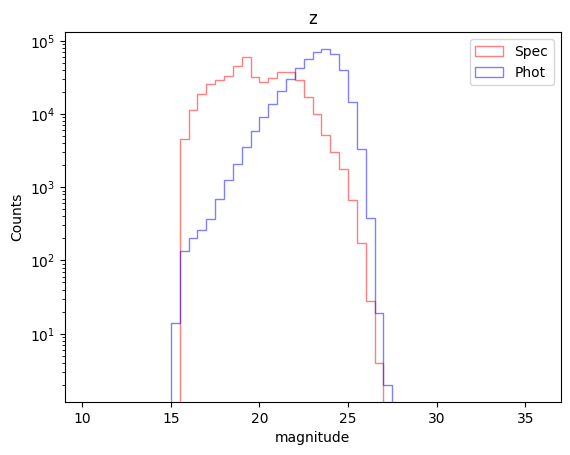

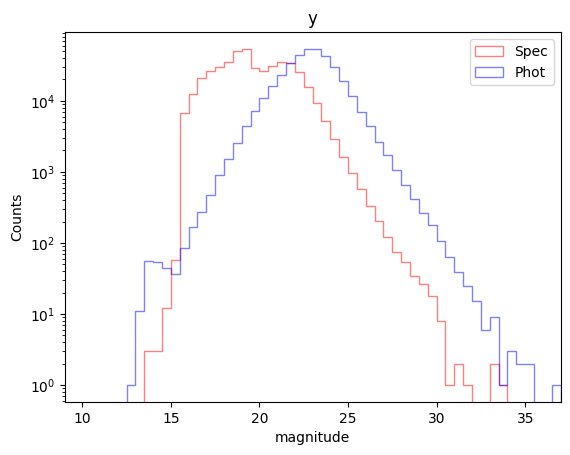

In [45]:
bands = ['g', 'r', 'i', 'z', 'y']
colors = ['blue', 'green', 'red', 'orange', 'purple']
plt.figure()
bins = np.linspace(9, 37, 57)
for i, (band, color) in enumerate(zip(bands,colors)):
    plt.hist(spec_sample[f'mag_auto_{band}_dered'], histtype='step', bins=bins, label='Spec', alpha = 0.5, edgecolor = "red")
    plt.hist(phot_sample[f'mag_auto_{band}'], histtype='step', bins=bins, label='Phot', alpha = 0.5, edgecolor = "blue")
    plt.title(band)
    plt.xlabel("magnitude")
    plt.ylabel("Counts")
    plt.xlim(9, 37)
    plt.yscale('log')
    plt.legend()
    plt.show()

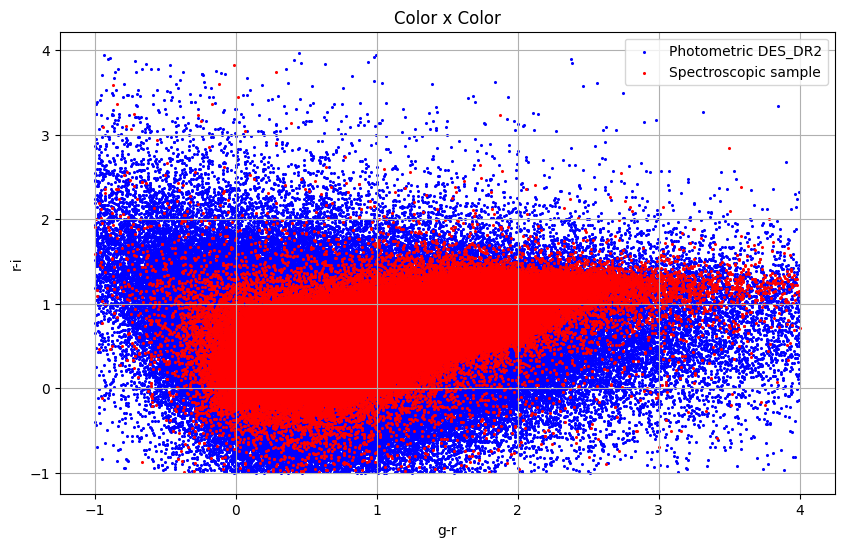

In [107]:
plt.figure(figsize = (10,6))
plt.scatter(gr_phot,ri_phot,color = 'blue', s =1.5, label = 'Photometric DES_DR2')
plt.scatter(gr_spec,ri_spec,color = 'red', s=1.5, label = 'Spectroscopic sample')
plt.xlabel('g-r')
plt.ylabel('r-i')
plt.legend()
plt.grid()
plt.title('Color x Color')
plt.savefig('cor-cor.png', dpi=300)

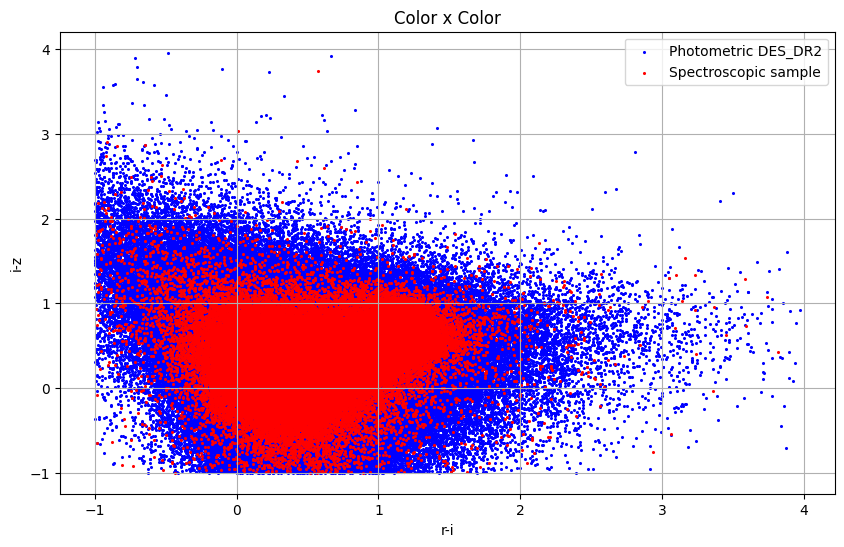

In [108]:
plt.figure(figsize = (10,6))
plt.scatter(ri_phot,iz_phot,color = 'blue', s =1.5, label = 'Photometric DES_DR2')
plt.scatter(ri_spec,iz_spec,color = 'red', s=1.5, label = 'Spectroscopic sample')
plt.xlabel('r-i')
plt.ylabel('i-z')
plt.legend()
plt.grid()
plt.title('Color x Color')
plt.savefig('cor-cor2.png', dpi=300)

# Spec analyses

## Mag distribution

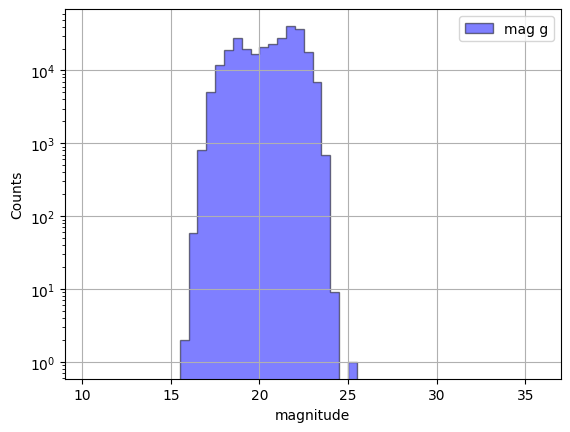

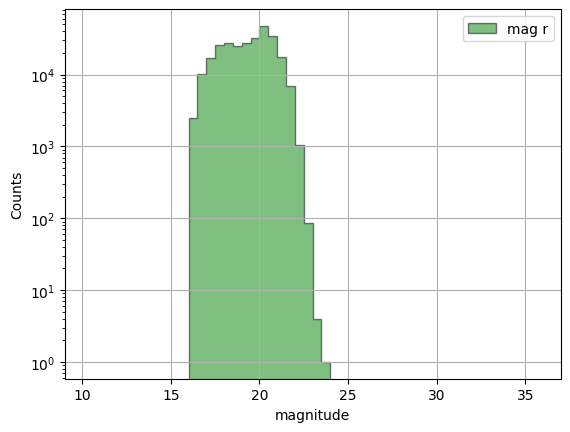

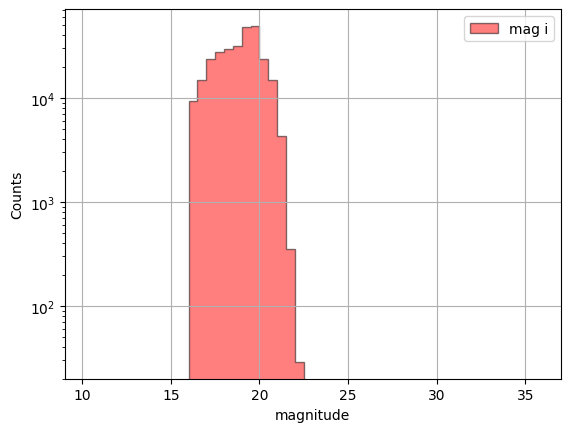

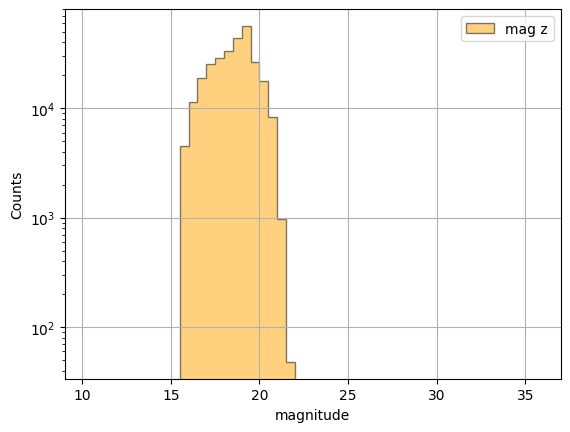

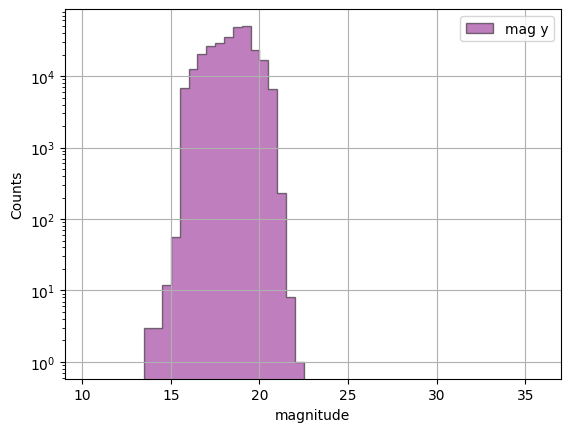

In [90]:
bands = ['g', 'r', 'i', 'z', 'y']
colors = ['blue', 'green', 'red', 'orange', 'purple']
plt.figure()
bins = np.linspace(9, 37, 57)
for i, (band, color) in enumerate(zip(bands,colors)):
    plt.hist(spec_sample[f'mag_auto_{band}_dered'], histtype='stepfilled', bins=bins, label=f'mag {band}', alpha = 0.5, edgecolor = "black", color = color)
    plt.xlabel("magnitude")
    plt.ylabel("Counts")
    plt.xlim(9, 37)
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

## Diagram mag x color for spec sample

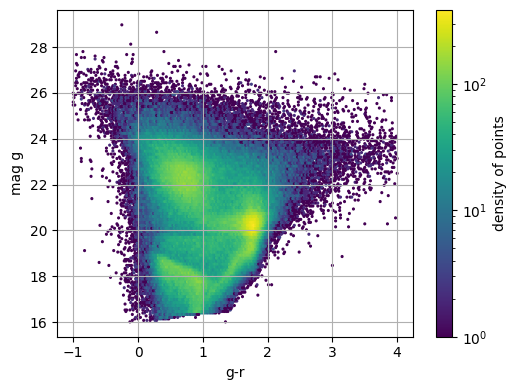

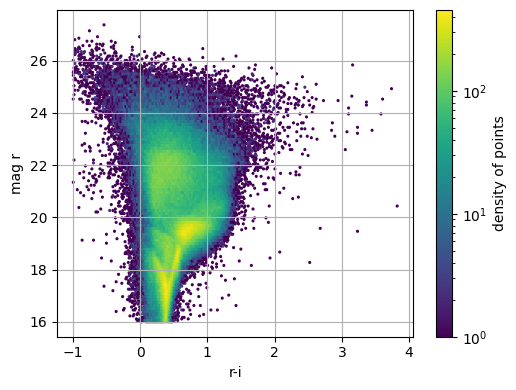

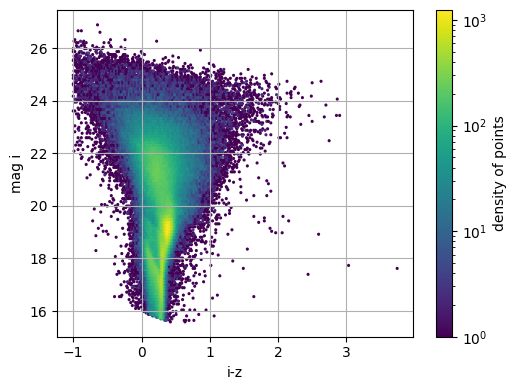

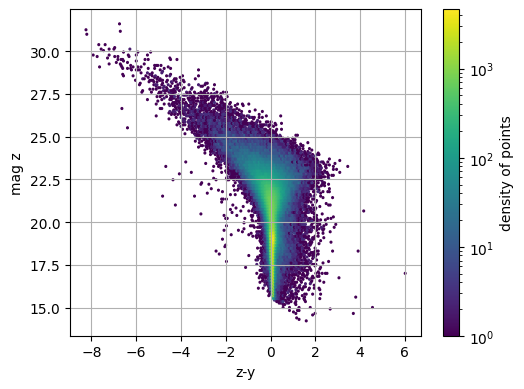

In [48]:
bands = ['g', 'r', 'i', 'z', 'y']
mag_diff = {}
for band,_band in zip(bands, bands[1::]):
    plt.figure(figsize=[10,4])
    plt.subplot(121)
    mag_diff = np.array(spec_sample[f'mag_auto_{band}_dered']) - np.array(spec_sample[f'mag_auto_{_band}_dered'])
    mag = np.array(spec_sample[f'mag_auto_{_band}_dered'])
                   
    mask = (mag>14)&(mag<32)&(mag_diff<10)
    plt.hexbin(mag_diff[mask], mag[mask], None, mincnt=1, cmap='viridis', gridsize=[200,100], bins='log')
    cbar = plt.colorbar(label='density of points')
    plt.ylabel("mag "+band)
    plt.xlabel(f"{band}-{_band}")
    plt.grid(True)
    plt.tight_layout()

## Mag x errors

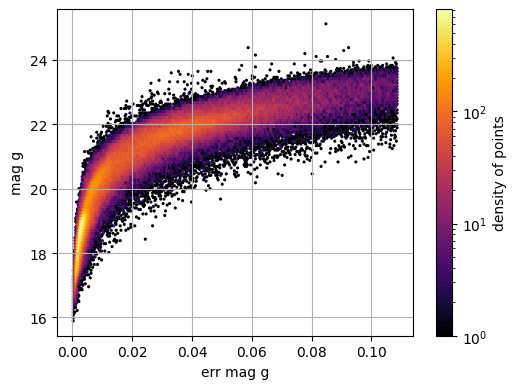

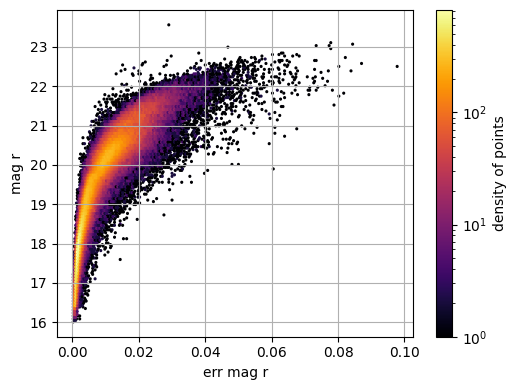

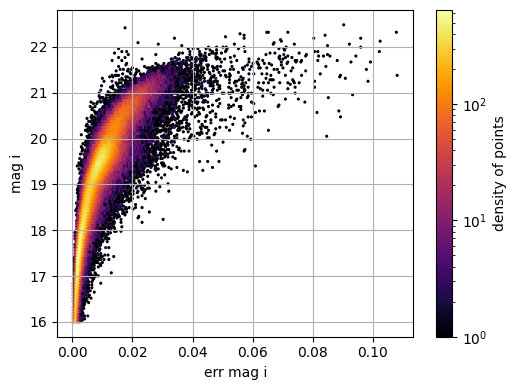

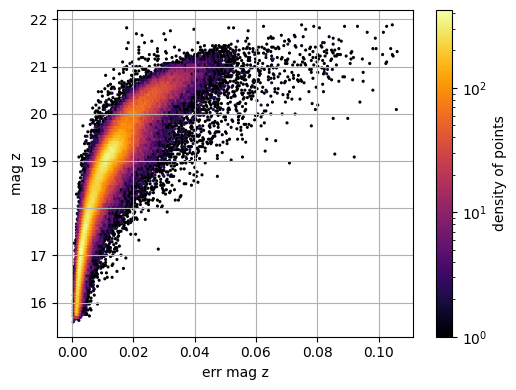

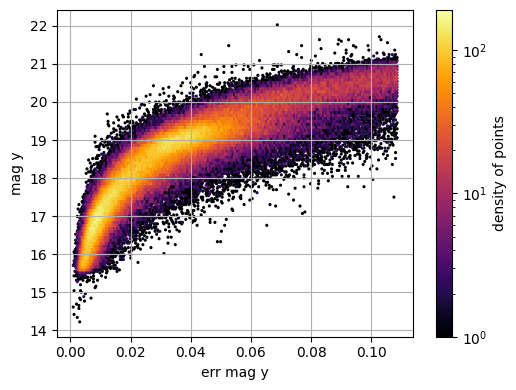

In [52]:
bands = ['g', 'r', 'i', 'z', 'y']
for i, band in enumerate(bands):
    plt.figure(figsize=[10,4])
    plt.subplot(121) 
    mag = np.array(spec_sample[f'mag_auto_{band}_dered'])
    err = np.array(spec_sample[f'magerr_auto_{band}'])
    mask = (mag>14)&(mag<32)&(err<10)
    plt.hexbin(err[mask], mag[mask], None, mincnt=1, cmap='inferno', gridsize=[200,100], bins='log')
    cbar = plt.colorbar(label='density of points')
    plt.ylabel("mag "+band)
    plt.xlabel("err mag "+band)
    plt.grid(True)
    plt.tight_layout()

## Studying z-high

In [177]:
zhigh = spec_sample[spec_sample['z']>1.5]


In [178]:
zhigh

,spec_id,z,err_z,flag,source,flag_des,coadd_object_id,ra,dec,mag_auto_g_dered,...,mag_auto_y_dered,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,g-r,r-i,i-z,z-y
168,125876,1.83305,0.000150,4.0,6DF,4,979602970,-16.798786,-40.792832,18.315022,...,18.300047,0.001176,0.001463,0.001968,0.003835,0.017463,0.017021,0.154215,-0.077066,-0.079195
419,126818,1.98911,0.000150,4.0,6DF,4,1058828972,-6.192905,-40.933154,18.201353,...,17.807959,0.000973,0.001047,0.001152,0.002167,0.008008,0.090328,0.324400,0.004814,-0.026148
633,127044,1.85789,0.000183,3.0,6DF,3,1023884429,-1.996921,-38.395970,17.720102,...,17.520208,0.001585,0.001429,0.001607,0.003319,0.011933,0.064613,0.227011,-0.023373,-0.068357
5407,47279,1.54133,99.000000,3.0,WIGGLEZ,3,936523371,-32.683674,-2.215380,20.753792,...,20.377392,0.011456,0.010917,0.013880,0.026860,0.106991,0.355700,0.149853,-0.039516,-0.089636
8257,49454,2.17508,99.000000,5.0,WIGGLEZ,4,940866518,-31.199138,-0.883445,20.270729,...,20.199808,0.005838,0.007096,0.009546,0.014205,0.064678,-0.073353,0.149014,0.182634,-0.187374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455850,231611,2.19182,0.000150,4.0,6DF,4,1381101258,48.749344,-45.757951,17.784521,...,17.706896,0.000987,0.001047,0.001425,0.002906,0.009418,0.045143,0.030972,0.101099,-0.099588
455862,231595,1.89221,0.000183,3.0,6DF,3,1356884582,44.833835,-45.957073,17.798044,...,17.349108,0.000760,0.000753,0.000972,0.001719,0.005338,0.201878,0.202669,0.043257,0.001133
456963,232488,1.54508,0.000150,4.0,6DF,4,1273776291,35.680693,-40.190228,17.666111,...,17.595453,0.000648,0.000658,0.000903,0.001754,0.007002,0.122974,0.111132,-0.078741,-0.084707
457173,232728,1.62556,0.000150,4.0,6DF,4,1295300599,38.812195,-38.093993,18.045527,...,17.850407,0.001050,0.001029,0.001614,0.002483,0.009425,0.102947,0.129969,0.040419,-0.078215


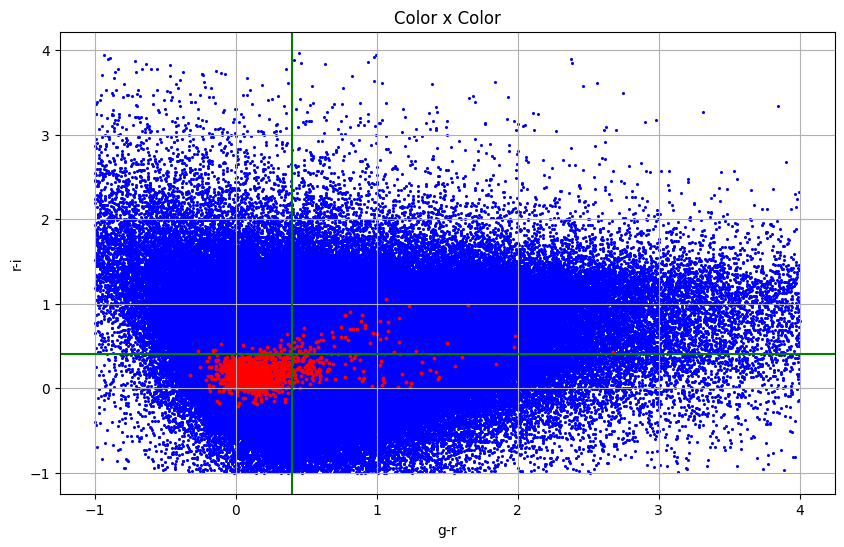

In [179]:
plt.figure(figsize = (10,6))
plt.scatter(gr_phot,ri_phot,color = 'blue', s =1.5, label = 'Photometric DES_DR2')
plt.scatter(zhigh['g-r'],zhigh['r-i'],color = 'red', s=3, label = 'Spectroscopic sample')
plt.xlabel('g-r')
plt.ylabel('r-i')
#plt.legend()
plt.grid()
plt.title('Color x Color')
plt.axhline(y=0.4, color='green')
plt.axvline(x=0.4, color='green')
#plt.xlim(-0.5,0.5)
#plt.ylim(-1,1)

Text(0.5, 1.0, 'Color x Color')

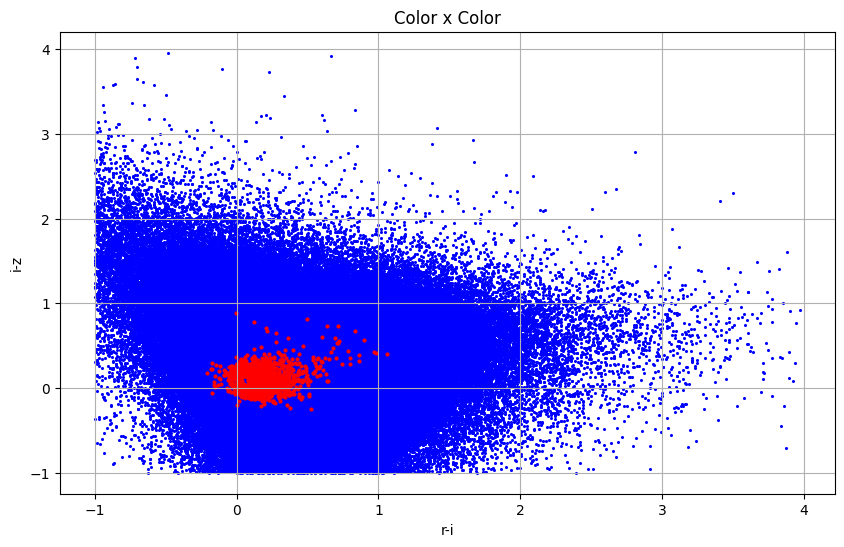

In [180]:
plt.figure(figsize = (10,6))
plt.scatter(ri_phot,iz_phot,color = 'blue', s =1.5, label = 'Photometric DES_DR2')
plt.scatter(zhigh['r-i'],zhigh['i-z'],color = 'red', s=4, label = 'Spectroscopic sample')
plt.xlabel('r-i')
plt.ylabel('i-z')
#plt.legend()
plt.grid()
plt.title('Color x Color')

In [181]:
surveys = set(zhigh['source'])
survey=[]
matchings=[]
z_mean=[]
z_max=[]
z_min=[]
for surv in surveys:
    survey.append(surv)
    mask = zhigh[zhigh['source']==surv]
    matchings.append(len(mask))
    z_mean.append(round(np.mean(mask['z']),2))
    z_max.append(round(max(mask['z']),2))
    z_min.append(round(min(mask['z']),2))
    

In [182]:
table = pd.DataFrame({'survey':survey, 'matchings':matchings, 'z_mean':z_mean, 'z_min':z_min, 'z_max':z_max})

In [183]:
table.sort_values(by='matchings', ascending = False)

,survey,matchings,z_mean,z_min,z_max
5,XXL_AAOMEGA,578,2.11,1.50,4.66
12,PANSTARRS,238,2.20,1.50,4.54
0,PRIMUS,151,2.07,1.50,3.87
15,2dFLenS,132,2.18,1.50,4.69
1,6DF,89,1.98,1.51,3.38
8,WIGGLEZ,60,1.85,1.53,4.24
11,STALIN,33,2.12,1.52,3.87
9,ATLAS,28,2.05,1.54,3.20
7,SDSS_DR14,20,1.74,1.53,1.98
10,CLASH-VLT,9,2.21,1.69,4.15


Text(0.5, 1.0, 'Color x Color')

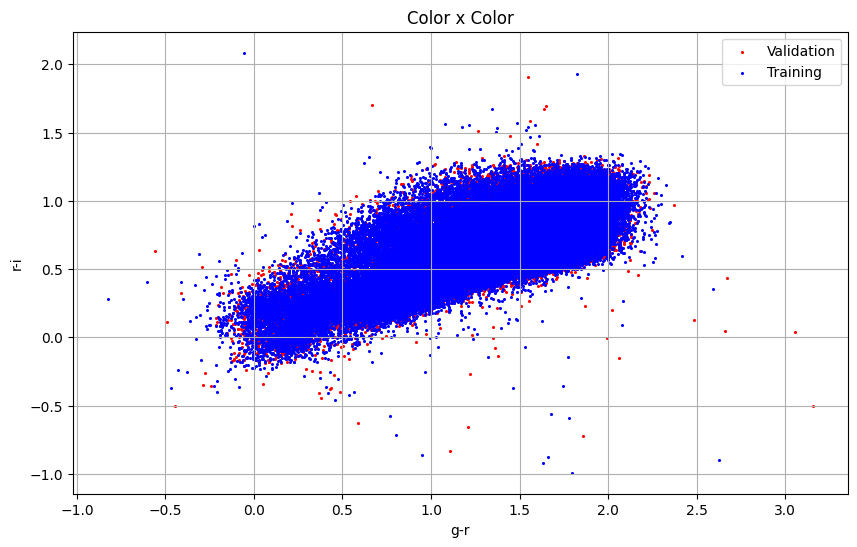

In [78]:
gr_val = validation['mag_auto_g_dered']-validation['mag_auto_r_dered']
ri_val = validation['mag_auto_r_dered']-validation['mag_auto_i_dered']
iz_val = validation['mag_auto_i_dered']-validation['mag_auto_z_dered']
gr_trai = training['mag_auto_g_dered']-training['mag_auto_r_dered']
ri_trai = training['mag_auto_r_dered']-training['mag_auto_i_dered']
iz_trai = training['mag_auto_i_dered']-training['mag_auto_z_dered']

plt.figure(figsize = (10,6))
plt.scatter(gr_val,ri_val,color = 'red', s =1.5, label = 'Validation')
plt.scatter(gr_trai,ri_trai,color = 'blue', s=1.5, label = 'Training')
plt.xlabel('g-r')
plt.ylabel('r-i')
plt.legend()
plt.grid()
plt.title('Color x Color')

## Separing 70% for training and 30% for validation

In [281]:
training = pd.DataFrame([])
validation = pd.DataFrame([])
for survey in surveys:
    obj = spec_sample[spec_sample['source']==survey]
    cut = int(round(0.7*len(obj),1))
    temp1= obj[:cut] #for training
    training = pd.concat([training, temp1], axis = 0)
    temp2= obj[cut:] #for validation
    validation = pd.concat([validation, temp2], axis = 0)

In [282]:
training

,spec_id,z,err_z,flag,source,flag_des,coadd_object_id,ra,dec,mag_auto_g_dered,...,mag_auto_y_dered,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,g-r,r-i,i-z,z-y
0,123965,0.116858,0.000183,3.0,6DF,3,943508938,-30.678677,-40.602543,17.459648,...,15.971371,0.001439,0.000954,0.001089,0.001607,0.005120,0.758184,0.363939,0.244530,0.121624
1,123966,0.301409,0.000150,4.0,6DF,4,943510809,-30.665829,-40.603863,17.726744,...,17.593048,0.000715,0.000725,0.001043,0.001577,0.006892,0.151939,0.010212,0.211040,-0.239496
2,123992,0.234609,0.000150,4.0,6DF,4,948663390,-28.560154,-40.971529,18.529400,...,17.983315,0.001417,0.001492,0.001679,0.003603,0.009086,0.190750,0.338978,-0.071640,0.087997
3,123993,0.147415,0.000150,4.0,6DF,4,945752705,-29.060350,-40.531142,18.018383,...,16.843912,0.001783,0.001381,0.001550,0.002662,0.009134,0.602333,0.371195,0.131882,0.069061
8,125601,0.046295,0.000150,4.0,6DF,4,956506888,-25.566652,-41.651011,16.598984,...,15.973599,0.000752,0.000693,0.001024,0.001810,0.005823,0.316784,0.096571,0.118837,0.093192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203099,7590,0.385300,99.000000,4.0,UDS,4,1262964570,34.659992,-5.253351,22.328362,...,20.451094,0.031152,0.014094,0.015248,0.022198,0.068007,1.175533,0.442039,0.287138,-0.027443
203563,7609,0.321200,99.000000,4.0,UDS,4,1262957938,34.529807,-5.184733,21.724926,...,19.602121,0.024068,0.011276,0.011885,0.017404,0.055932,1.175304,0.438826,0.285559,0.223116
204109,7655,0.497300,99.000000,4.0,UDS,4,1262962143,34.723224,-5.237342,21.396191,...,18.967535,0.023733,0.009388,0.009481,0.012398,0.039157,1.329210,0.523558,0.376696,0.199192
204137,7657,0.646700,99.000000,4.0,UDS,4,1262967219,34.749436,-5.282085,22.833750,...,20.417143,0.050502,0.023246,0.021611,0.027786,0.077615,1.189634,0.621258,0.375734,0.229980


In [283]:
validation

,spec_id,z,err_z,flag,source,flag_des,coadd_object_id,ra,dec,mag_auto_g_dered,...,mag_auto_y_dered,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,g-r,r-i,i-z,z-y
446513,222430,0.101340,0.00015,4.0,6DF,4,987285055,-14.470250,-59.913633,17.277409,...,15.756319,0.000907,0.000602,0.000608,0.000916,0.002879,0.788319,0.402422,0.217178,0.113171
446514,222394,0.208611,0.00015,4.0,6DF,4,987192972,-14.820068,-61.946905,18.222847,...,16.144840,0.002253,0.000992,0.001136,0.001687,0.005067,1.218351,0.418386,0.314701,0.126568
446515,222431,0.149126,0.00015,4.0,6DF,4,993187700,-13.907601,-60.301470,18.832737,...,17.055300,0.001705,0.000903,0.000960,0.001313,0.004224,1.038092,0.388571,0.294441,0.056334
446520,222395,0.209605,0.00015,4.0,6DF,4,982501416,-16.472006,-61.610615,17.563343,...,16.919676,0.000826,0.000864,0.000994,0.002011,0.005903,0.283745,0.348038,-0.033083,0.044968
446523,222438,0.461533,0.00015,4.0,6DF,4,968519113,-22.687569,-58.158286,19.162849,...,17.784220,0.002361,0.003101,0.003985,0.004199,0.008454,0.026812,0.249964,0.526712,0.575142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212046,8021,0.867000,99.00000,4.0,UDS,4,1262950678,34.866178,-5.108414,21.284184,...,20.101830,0.014250,0.013101,0.013372,0.019152,0.060569,0.353130,0.531393,0.315821,-0.017990
212065,8017,0.516900,99.00000,3.0,UDS,3,1262948466,34.827172,-5.087723,22.595884,...,19.782362,0.053380,0.016601,0.014335,0.019445,0.048998,1.611954,0.667599,0.423946,0.110023
212265,8034,0.427400,99.00000,4.0,UDS,4,1262945185,34.894560,-5.052509,21.686396,...,19.173149,0.037215,0.011803,0.011350,0.015185,0.041065,1.581947,0.550047,0.296843,0.084410
212918,8071,0.767200,99.00000,3.0,UDS,3,1262926739,34.841478,-4.850100,22.978783,...,20.322662,0.087111,0.041939,0.031739,0.039958,0.080269,1.096033,0.843330,0.435162,0.281595


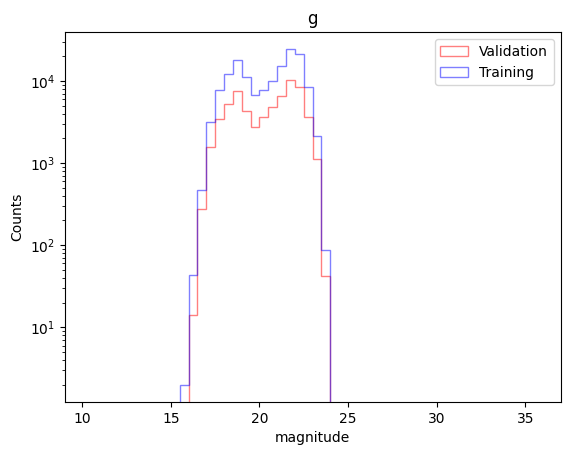

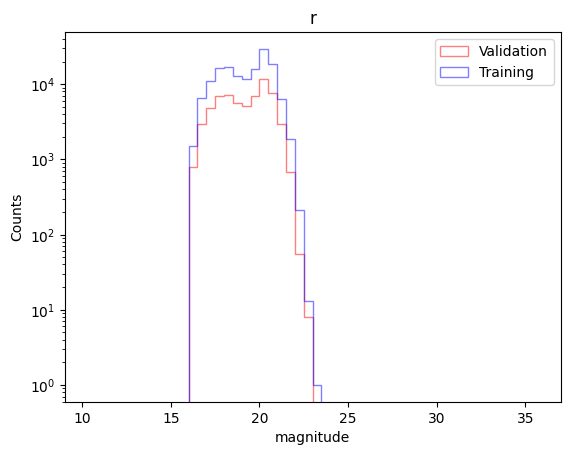

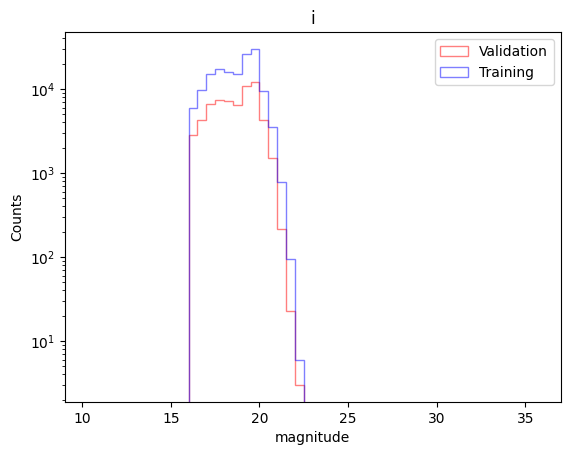

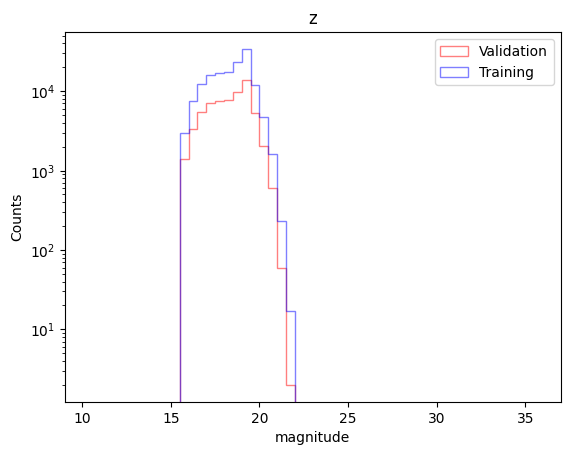

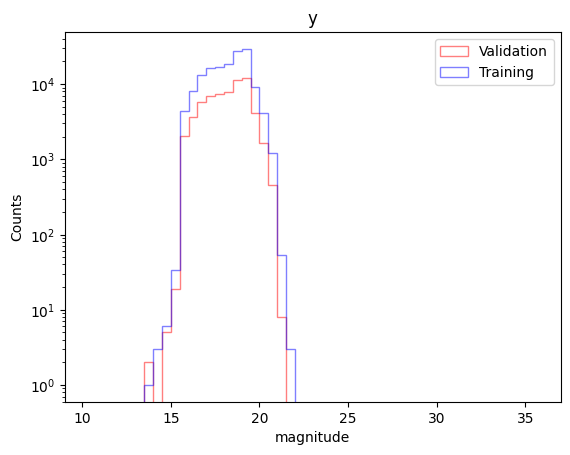

In [284]:
bands = ['g', 'r', 'i', 'z', 'y']
colors = ['blue', 'green', 'red', 'orange', 'purple']
plt.figure()
bins = np.linspace(9, 37, 57)
for i, (band, color) in enumerate(zip(bands,colors)):
    plt.hist(validation[f'mag_auto_{band}_dered'], histtype='step', bins=bins, label='Validation', alpha = 0.5, edgecolor = "red")
    plt.hist(training[f'mag_auto_{band}_dered'], histtype='step', bins=bins, label='Training', alpha = 0.5, edgecolor = "blue")
    plt.title(band)
    plt.xlabel("magnitude")
    plt.ylabel("Counts")
    plt.xlim(9, 37)
    plt.yscale('log')
    plt.legend()
    plt.show()

## Saving the data

In [285]:

del validation['coadd_object_id'],validation['spec_id'], validation['source'], validation['err_z'], validation['flag'], validation['flag_des'], validation['ra'], validation['dec']
del training['coadd_object_id'],training['spec_id'], training['source'], training['err_z'], training['flag'], training['flag_des'], training['ra'], training['dec']


In [286]:
validation.columns = ['#zs','g','r','i','z','y','eg','er','ei','ez','ey','g-r','r-i','i-z','z-y']
training.columns = ['#zs','g','r','i','z','y','eg','er','ei','ez','ey','g-r','r-i','i-z','z-y']

In [287]:
validation['eg-r'] = validation['eg']-validation['er']
validation['er-i'] = validation['er']-validation['ei']
validation['ei-z'] = validation['ei']-validation['ez']
validation['ez-y'] = validation['ez']-validation['ey']
training['eg-r'] = training['eg']-training['er']
training['er-i'] = training['er']-training['ei']
training['ei-z'] = training['ei']-training['ez']
training['ez-y'] = training['ez']-training['ey']

In [288]:
validation.to_csv('/home/iago.dias/MLZ/mlz/test/validation.DR2', sep=' ', index = False)
training.to_csv('/home/iago.dias/MLZ/mlz/test/training.DR2', sep=' ', index = False)

In [289]:
validation.to_csv('/home/iago.dias/Plots-TPZ/iago/ml_analyses/validation', sep=' ', index = False)
training.to_csv('/home/iago.dias/Plots-TPZ/iago/ml_analyses/training', sep=' ', index = False)

In [290]:
training


,#zs,g,r,i,z,y,eg,er,ei,ez,ey,g-r,r-i,i-z,z-y,eg-r,er-i,ei-z,ez-y
0,0.116858,17.459648,16.701464,16.337524,16.092995,15.971371,0.001439,0.000954,0.001089,0.001607,0.005120,0.758184,0.363939,0.244530,0.121624,0.000485,-0.000134,-0.000519,-0.003513
1,0.301409,17.726744,17.574804,17.564592,17.353552,17.593048,0.000715,0.000725,0.001043,0.001577,0.006892,0.151939,0.010212,0.211040,-0.239496,-0.000010,-0.000318,-0.000534,-0.005315
2,0.234609,18.529400,18.338650,17.999672,18.071312,17.983315,0.001417,0.001492,0.001679,0.003603,0.009086,0.190750,0.338978,-0.071640,0.087997,-0.000075,-0.000187,-0.001924,-0.005482
3,0.147415,18.018383,17.416050,17.044855,16.912973,16.843912,0.001783,0.001381,0.001550,0.002662,0.009134,0.602333,0.371195,0.131882,0.069061,0.000401,-0.000169,-0.001112,-0.006472
8,0.046295,16.598984,16.282200,16.185629,16.066792,15.973599,0.000752,0.000693,0.001024,0.001810,0.005823,0.316784,0.096571,0.118837,0.093192,0.000058,-0.000331,-0.000785,-0.004013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203099,0.385300,22.328362,21.152828,20.710789,20.423651,20.451094,0.031152,0.014094,0.015248,0.022198,0.068007,1.175533,0.442039,0.287138,-0.027443,0.017058,-0.001154,-0.006950,-0.045809
203563,0.321200,21.724926,20.549622,20.110796,19.825237,19.602121,0.024068,0.011276,0.011885,0.017404,0.055932,1.175304,0.438826,0.285559,0.223116,0.012792,-0.000609,-0.005519,-0.038529
204109,0.497300,21.396191,20.066980,19.543423,19.166727,18.967535,0.023733,0.009388,0.009481,0.012398,0.039157,1.329210,0.523558,0.376696,0.199192,0.014345,-0.000093,-0.002916,-0.026759
204137,0.646700,22.833750,21.644115,21.022858,20.647123,20.417143,0.050502,0.023246,0.021611,0.027786,0.077615,1.189634,0.621258,0.375734,0.229980,0.027256,0.001635,-0.006175,-0.049829


In [291]:
max(spec_sample['z'])

4.68802